# Numbers about the switches
## Read data

In [1]:
source("~/smartas/pipeline/scripts/variablesAndFunctions.r")

# read consensus, not noise, switches
switches <- read_tsv("../data/pancancer/candidateList_info.agg.tsv") %>%
    filter(NotNoise==1 & IsModel==1)

# read mutations
wes <- read_tsv("../data//mutations/wes_mutations.txt") %>%
    select(Tumor,Gene,Symbol,Patient) %>%
    unique

wgs <- read_tsv("../data//mutations/wgs_mutations.txt") %>%
    select(Tumor,Gene,Symbol,Patient) %>%
    unique


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
: 497148 parsing failures.
row col  expected    actual
  1  -- 7 columns 6 columns
  2  -- 7 columns 6 columns
  3  -- 7 columns 6 columns
  4  -- 7 columns 6 columns
  5  -- 7 columns 6 columns
... ... ......... .........
.See problems(...) for more details.

## Some stats about switches

In [2]:
# num switches
nrow(switches)

# num genes
nrow(unique(switches[,c('GeneId','Symbol')]))

[1] 11019

[1] 7956

In [3]:
# Numbers
# two protein coding isoforms
sum(switches$CDS_Normal & switches$CDS_Tumor)

# only normal isoform
sum(switches$CDS_Normal & !switches$CDS_Tumor)

# only tumor isoform
sum(!switches$CDS_Normal & switches$CDS_Tumor)

# Percentages
# two protein coding isoforms
sum(switches$CDS_Normal & switches$CDS_Tumor)/nrow(switches) * 100

# only normal isoform
sum(switches$CDS_Normal & !switches$CDS_Tumor)/nrow(switches) * 100

# only tumor isoform
sum(!switches$CDS_Normal & switches$CDS_Tumor)/nrow(switches) * 100

[1] 9444

[1] 1016

[1] 287

[1] 85.70651

[1] 9.220437

[1] 2.604592

In [4]:
# two protein coding isoforms
# functional
# number
sum(switches$CDS_Normal & switches$CDS_Tumor & switches$IsFunctional)
# percentage
sum(switches$CDS_Normal & switches$CDS_Tumor & switches$IsFunctional)/sum(switches$CDS_Normal & switches$CDS_Tumor) * 100

[1] 7235

[1] 76.60949

In [5]:
# unbalance between only niso and only tiso
x <- sum(switches$CDS_Normal & !switches$CDS_Tumor)
n <- sum(!switches$CDS_Normal & switches$CDS_Tumor)+sum(switches$CDS_Normal & !switches$CDS_Tumor)
binom.test(x,n,0.5)


	Exact binomial test

data:  x and n
number of successes = 1016, number of trials = 1303, p-value < 2.2e-16
alternative hypothesis: true probability of success is not equal to 0.5
95 percent confidence interval:
 0.7562355 0.8019735
sample estimates:
probability of success 
             0.7797391 


## Stats about patient recurrence
We will use mutation data to put switch data into context.

In [6]:
genesWESMutated <- wes %>%
    group_by(Tumor,Patient) %>%
    summarise(WES=length(Patient))

genesWGSMutated <- wgs %>%
    group_by(Tumor,Patient) %>%
    summarise(WGS=length(Patient))

genesSwitched <- as.data.frame(table(unlist(strsplit(switches$Patients_affected,",")))) %>%
    set_colnames(c("Patient","Switch"))

recurrence <- merge(genesSwitched,genesWESMutated,all=T) %>%
    merge(genesWGSMutated,all=T)

Using Patient, Tumor as id variables
Warning message:
: Removed 7056 rows containing non-finite values (stat_boxplot).

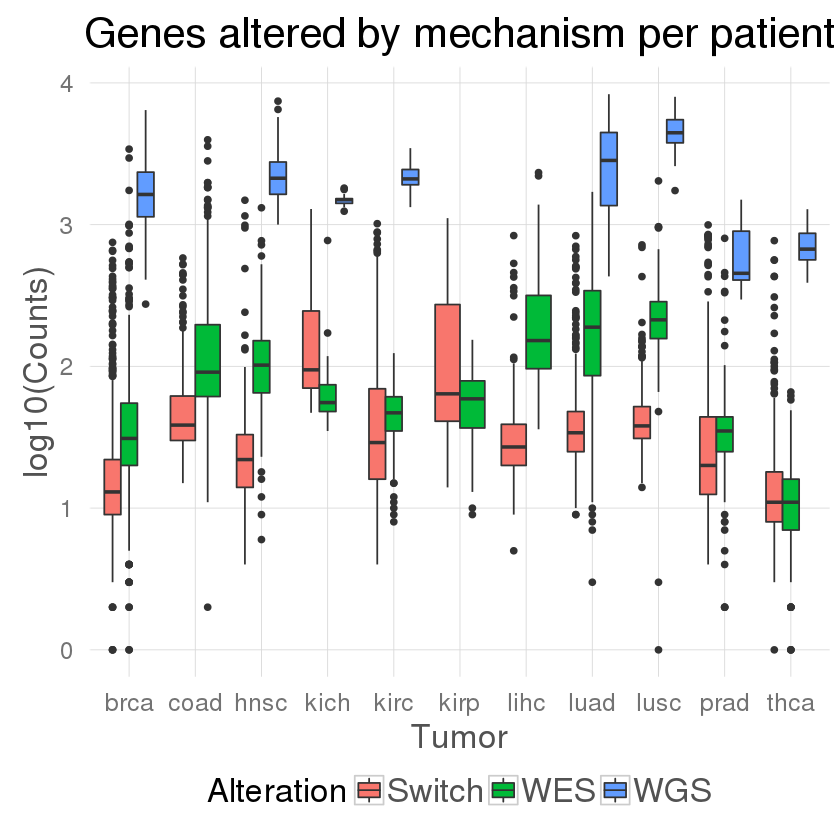

In [7]:
# show distribution of genes affected through each mechanism per patient
recurrence %>%
    melt %>%
    set_colnames(c("Patient","Tumor","Alteration","Counts")) %>%
    ggplot(aes(x=Tumor,y=log10(Counts), fill=Alteration)) +
    geom_boxplot() + 
    smartas_theme() +
    theme(legend.position="bottom") +
    labs(title="Genes altered by mechanism per patient")

Warning message:
: Removed 1307 rows containing missing values (geom_point).

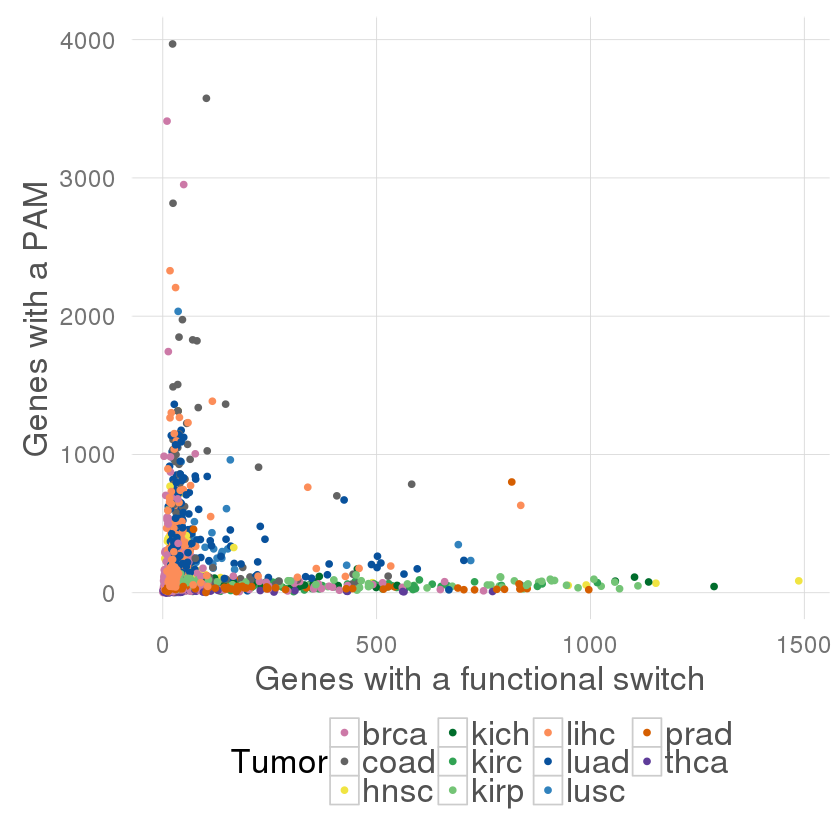

In [8]:
# show lack of correlation between mutations and switches
recurrence %>%
    ggplot(aes(x=Switch,y=WES)) + 
    geom_point(aes(color=Tumor)) + 
    smartas_theme() +
    scale_color_manual(values=colorPalette) + 
    theme(legend.position="bottom") +
    labs(x="Genes with a functional switch", y="Genes with a PAM")